# PSO Fitting Testing

In [ ]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel, BiphasicAxonMapSpatial
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

## Do 12-005 S2

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

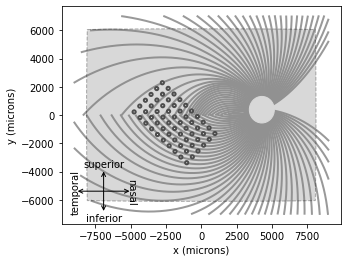

In [2]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2, biphasic=False)
model.xystep=0.25

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')

data = data[(data['amp1'] == 2) & (data['freq'] == 20)]
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y.iloc[0].shape

estimator = shapes.AxonMapEstimator(implant=implant, model=model, mse_params=['area', 'eccentricity', 'orientation'], loss_fn='r2', scale_features=False)
search_params = {
#     'a5' : (0, 5),
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
model.build()
model.plot()
implant.plot()

In [ ]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

In [14]:
estimator = shapes.AxonMapEstimator(implant=implant, model=model, mse_params=['area', 'eccentricity', 'orientation'], loss_fn='r2')
search_params = {
#     'a5' : (0, 5),
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)
y_moments = estimator.compute_moments(y)
data[['area', 'eccentricity', 'orientation']] = y_moments
averaged_moments = data.groupby(['amp1', 'freq', 'pdur', 'electrode1'])['area', 'eccentricity', 'orientation'].mean()
x = data[['amp1', 'freq', 'pdur', 'electrode1']].drop_duplicates()

Removing means (['area: 636.53', 'eccentricity: 0.86', 'orientation: 0.01']) 
Scaling standard deviations (['area: 434.34', 'eccentricity: 0.16', 'orientation: 0.95']) to be 1


In [15]:
estimator.score(x, averaged_moments)
opt.fit(x, averaged_moments)
estimator.score(x, averaged_moments)

score:18.747, rho:200.0, lambda:200.0, empty:0, mses:['area:1.1', 'eccentricity:13.8', 'orientation:3.9']
score:803.233, rho:617.3, lambda:1104.7, empty:0, mses:['area:791.0', 'eccentricity:7.7', 'orientation:4.5']
score:7.601, rho:46.3, lambda:1104.0, empty:0, mses:['area:2.7', 'eccentricity:2.4', 'orientation:2.5']
score:75.718, rho:357.3, lambda:64.2, empty:0, mses:['area:25.6', 'eccentricity:46.7', 'orientation:3.5']
score:60.584, rho:329.4, lambda:647.3, empty:0, mses:['area:51.6', 'eccentricity:5.7', 'orientation:3.3']
score:2104.230, rho:895.0, lambda:189.1, empty:0, mses:['area:2050.0', 'eccentricity:50.3', 'orientation:4.0']
score:219.837, rho:458.5, lambda:751.9, empty:0, mses:['area:207.3', 'eccentricity:8.0', 'orientation:4.6']
score:180.879, rho:303.6, lambda:1929.1, empty:0, mses:['area:174.1', 'eccentricity:3.6', 'orientation:3.2']
score:2250.436, rho:912.2, lambda:119.3, empty:0, mses:['area:2195.0', 'eccentricity:51.7', 'orientation:3.8']
score:76.130, rho:346.6, lambd

6.544188038977456

In [ ]:
params1 = estimator.get_params()
params1

In [ ]:
import random
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
estimator.set_params(**params1)
estimator.fit(x, y)
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample(list(x.index), 10)):
    img = resize(center_image(preds[img_idx] > 0.65), y[img_idx].shape)
    area = np.sum(img)
    axes[plt_idx, 0].imshow(img, cmap="gray")
    props = measure.regionprops(measure.label(img))
    axes[plt_idx, 0].set_title("Predicted. Area:%.2f, Ecc:%.2f" % (area, props[0].eccentricity))
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    props = measure.regionprops(measure.label(center_image(y[img_idx])))
    prop = max(props, key = lambda x : x.area)
    axes[plt_idx, 1].set_title("Actual. Area:%.2f, Ecc:%.2f" % (np.sum(y[img_idx]), prop.eccentricity))
fig.show()
estimator.score(x, y_moments)

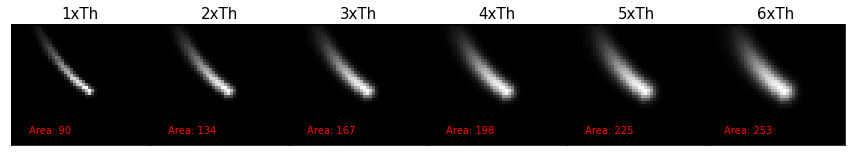

In [6]:
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.implants import ProsthesisSystem, DiskElectrode
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font = {'fontname':'Arial'}

import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(1, 6, sharex=True, sharey=True)#, gridspec_kw={'height_ratios': [2.5, 1, 1]})
fig.subplots_adjust(wspace=0, hspace=-0.35)

amps = [1, 2, 3, 4, 5, 6]
freqs = [5, 10, 20,40, 80, 120]
pdurs_1 = [0.1, 0.5, 1, 5, 10]
pdurs_2 = [.1, 1, 5, 25, 50, 100]
# ticks = [-6.0, -3.0, 0.0, 3.0]
plotborder = 1.5
ticks = []
model = BiphasicAxonMapModel(axlambda=estimator.axlambda, rho=estimator.rho, do_thresholding=False, yrange=(0, 10), xrange=(-6.5, 5))
model.a5 = estimator.a5
model.a6 = estimator.a6
model.build()
implant = ProsthesisSystem(DiskElectrode(0, 1500, 10, 200))

for i, amp in enumerate(amps):
    ax = axes[i]
    fig.sca(ax)
    stim = BiphasicPulseTrain(5, amp, 0.45)
    implant.stim = stim
    percept = model.predict_percept(implant)
    percept.plot(figsize=(11.5 * 1.3, 10 * 1.3))
    ax.set_title("" + str(amp) + "xTh", fontsize=15, **font)
    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("")
#         ax.set_ylabel("Amplitude", fontweight='bold', fontsize=14)
    ax.set_xlabel("")
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_ylim(0, 10)
    area = np.sum(percept.data > (percept.data.max() - percept.data.min()) * 0.1 + percept.data.min())
    ax.annotate("Area: {:d}".format(area), (-5, 1), color='r')

    
fig.show()

### Unstandardized mses

In [4]:
estimator.mse_params = ['moments_central', "area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation"]
estimator.scale_features = False
new_y_moments = estimator.compute_moments(y, fit_scaler=False)
estimator.score(x, new_y_moments)

Warning, got different length feature_importances and mse_params. Did you set one manually?
Defaulting to equal weighting
score=11791400626093288.000, rho=200.0, lambda=200.0, a5=1.081, a6=-0.353, mses: ['M00: 547970.197', 'M02: 37707208160.562', 'M11: 8851765103.171', 'M12: 175017656640.709', 'M20: 23336645998.738', 'M21: 106765878002.187', 'M22: 1.1791048945841724e+16', 'area: 547970.197', 'eccentricity: 0.229', 'major_axis_length: 1371.235', 'minor_axis_length: 346.584', 'orientation: 1.003']


1.1791400626093288e+16

### Standardized mses

In [6]:
estimator.mse_params = ['moments_central', "area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation"]
estimator.scale_features=True
new_y_moments = estimator.compute_moments(y, fit_scaler=True)
estimator.score(x, new_y_moments)

Removing means (['M00: 560.18', 'M02: 95102.63', 'M11: 24202.46', 'M12: -46893.36', 'M20: 65115.72', 'M21: -50567.79', 'M22: 31353163.63', 'area: 560.18', 'eccentricity: 0.87', 'major_axis_length: 58.04', 'minor_axis_length: 18.48', 'orientation: 0.06']) 
Scaling standard deviations (['M00: 392.19', 'M02: 130835.05', 'M11: 93802.57', 'M12: 416635.68', 'M20: 76773.64', 'M21: 322264.26', 'M22: 102740688.22', 'area: 392.19', 'eccentricity: 0.15', 'major_axis_length: 29.93', 'minor_axis_length: 9.21', 'orientation: 0.94']) to be 1
score=33.902, rho=200.0, lambda=200.0, a5=1.081, a6=-0.353, mses: ['M00: 3.563', 'M02: 2.203', 'M11: 1.006', 'M12: 1.008', 'M20: 3.959', 'M21: 1.028', 'M22: 1.117', 'area: 3.563', 'eccentricity: 9.699', 'major_axis_length: 1.531', 'minor_axis_length: 4.082', 'orientation: 1.143']


33.90164057294065

## Fit size model first

In [1]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

In [2]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2)#, offset=(-50, 50, -0.25))
model.xystep=0.25
data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape

mse_params=['area', "major_axis_length", "minor_axis_length"]
estimator = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, resize=True, loss_fn='r2', scale_features=False, mse_params=mse_params)
search_params = {
    'rho': (10, 500),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=50, has_loss_function=True)

estimator.fit_size_model(x['amp1'], y)
y_moments = estimator.compute_moments(y)
data[mse_params] = y_moments
averaged_moments = data.groupby(['amp1', 'freq', 'pdur', 'electrode1'])[mse_params].mean()
x = data[['amp1', 'freq', 'pdur', 'electrode1']].drop_duplicates()
model.build()
print()
# model.plot()
# implant.plot()


a5=0.185353, a6=0.629293



In [ ]:
estimator.rho = 130
estimator.axlambda = 493.9
estimator.fit(None)
estimator.score(x, averaged_moments)

In [17]:
estimator.score(x, averaged_moments)
opt.fit(x, averaged_moments)
estimator.score(x, averaged_moments)

score:6.918, rho:130.0, lambda:487.0, a5:0.185, empty:0, scores: ['area:1.2', 'orientation:3.4', 'eccentricity:2.3']
score:44.572, rho:194.0, lambda:1853.7, a5:0.185, empty:0, scores: ['area:38.3', 'orientation:3.2', 'eccentricity:3.0']
score:10.836, rho:183.4, lambda:640.6, a5:0.185, empty:0, scores: ['area:4.6', 'orientation:3.4', 'eccentricity:2.9']
score:17.849, rho:142.9, lambda:1526.8, a5:0.185, empty:0, scores: ['area:12.2', 'orientation:3.0', 'eccentricity:2.7']
score:10.208, rho:95.0, lambda:1661.3, a5:0.185, empty:0, scores: ['area:4.8', 'orientation:2.8', 'eccentricity:2.5']
score:77.623, rho:293.0, lambda:1269.7, a5:0.185, empty:0, scores: ['area:70.4', 'orientation:3.5', 'eccentricity:3.8']
score:138.027, rho:323.0, lambda:1672.9, a5:0.185, empty:0, scores: ['area:130.6', 'orientation:3.5', 'eccentricity:3.9']
score:58.154, rho:268.9, lambda:1201.0, a5:0.185, empty:0, scores: ['area:50.9', 'orientation:3.5', 'eccentricity:3.8']
score:6.701, rho:48.6, lambda:1382.8, a5:0.18

6.673751918161109

In [20]:
preds = estimator.predict(x)

In [21]:
preds[0].shape

(384, 512)

In [19]:
params2 = estimator.get_params()
params2

{'rho': 113.90810204313115,
 'axlambda': 458.3725649339826,
 'a0': 2.095,
 'a1': 0.054326,
 'a2': 0.1492147,
 'a3': 0.0163851,
 'a4': 0,
 'a5': 0.18535347,
 'a6': 0.6292930543422699,
 'a7': 0.54,
 'a8': 0.21,
 'a9': 1.56}

In [ ]:
import random
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
estimator.set_params(**params2)
estimator.fit(x, y)
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample([i for i in range(len(x))], 10)):
    img = resize(center_image(preds[img_idx] > (preds[img_idx].max() - preds[img_idx].min()) * 0.1 + preds[img_idx].min()), y[img_idx].shape)
    area = np.sum(img)
    axes[plt_idx, 0].imshow(img, cmap="gray")
    props = measure.regionprops(measure.label(img))
    axes[plt_idx, 0].set_title("Predicted. Area:%.2f, Ecc:%.2f" % (area, props[0].eccentricity))
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    props = measure.regionprops(measure.label(center_image(y[img_idx])))
    prop = max(props, key = lambda x : x.area)
    axes[plt_idx, 1].set_title("Actual. Area:%.2f, Ecc:%.2f" % (np.sum(y[img_idx]), prop.eccentricity))
fig.show()
estimator.score(x, y_moments)

## AxonMap

In [16]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

Removing means (['M00: 572.78', 'M02: 118251.72', 'M11: 12787.84', 'M12: -142800.68', 'M20: 80173.9', 'M21: -112306.35', 'M22: 52262131.65']) 
Scaling standard deviations (['M00: 386.2', 'M02: 154667.97', 'M11: 124106.3', 'M12: 1342767.19', 'M20: 94607.6', 'M21: 1143759.61', 'M22: 145068970.21']) to be 1


<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

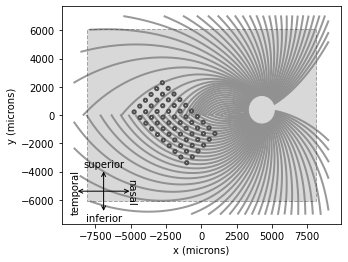

In [17]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2, biphasic=False)
model.xystep=0.5

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape

estimator = shapes.AxonMapEstimator(implant=implant, model=model, resize=True, mse_params=['moments_central'])
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
model.build()
model.plot()
implant.plot()

In [ ]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

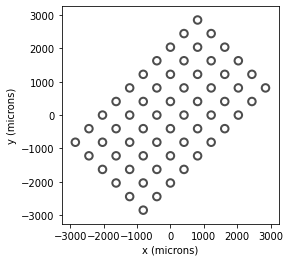

In [13]:
t = ArgusII(rot=45)
t.plot()

## Nanduri

In [1]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel, BiphasicAxonMapSpatial, Model, Nanduri2012Temporal, ScoreboardSpatial, AxonMapSpatial
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
from pulse2percept.stimuli import BiphasicPulseTrain
import shapes

import matplotlib.pyplot as plt
import numpy as np
import time

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

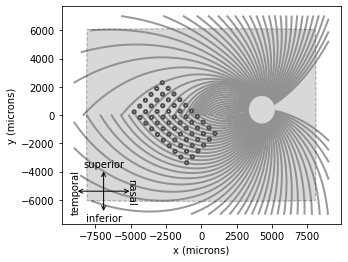

In [2]:
s2 = shapes.subject_params['12-005']
model = Model(spatial=AxonMapSpatial(), temporal=Nanduri2012Temporal())
implant, model = shapes.model_from_params(s2, biphasic=False, model=model)
model.xystep=0.5
model.dt=0.1


data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')

x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y.iloc[0].shape

estimator = shapes.NanduriAxonMapEstimator(implant=implant, model=model, mse_params=['area', "major_axis_length", "minor_axis_length"], loss_fn='r2', scale_features=False, resize=True)
search_params = {
#     'a5' : (0, 5),
    'rho': (10, 500),
    'axlambda': (10, 2000),
    'tau1' : (0, 1.25),
    'tau2' : (20, 90),
    'tau3' : (10, 50),
    'slope' : (1.5, 6),
    'shift' : (8, 32)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
data[['area', 'eccentricity', 'orientation']] = y_moments
averaged_moments = data.groupby(['amp1', 'freq', 'pdur', 'electrode1'])['area', 'eccentricity', 'orientation'].mean()
x = data[['amp1', 'freq', 'pdur', 'electrode1']].drop_duplicates()
model.build()
model.plot()
implant.plot()

In [ ]:
start = time.time()
estimator.score(x, averaged_moments)
opt.fit(x, averaged_moments)
estimator.score(x, averaged_moments)
end = time.time()
print (start - end)

score:103503.319, rho:407.4, lam:389.0, tau1:0.34, tau2:63.96, tau3:25.76, eps:8.73, asym:14.00, slope:3.9, shift:24.4, scores: ['area:101574.5', 'major_axis_length:236.2', 'minor_axis_length:1692.6']
score:17.275, rho:44.2, lam:1768.4, tau1:1.16, tau2:45.91, tau3:26.99, eps:8.73, asym:14.00, slope:3.0, shift:23.1, scores: ['area:4.6', 'major_axis_length:6.9', 'minor_axis_length:5.8']
score:229023.940, rho:464.5, lam:1122.7, tau1:0.83, tau2:24.00, tau3:21.52, eps:8.73, asym:14.00, slope:5.4, shift:25.2, scores: ['area:226353.9', 'major_axis_length:427.2', 'minor_axis_length:2242.8']
score:79477.413, rho:344.0, lam:1101.1, tau1:0.32, tau2:38.54, tau3:12.52, eps:8.73, asym:14.00, slope:5.7, shift:22.8, scores: ['area:77941.8', 'major_axis_length:228.9', 'minor_axis_length:1306.7']
score:84469.892, rho:359.9, lam:861.8, tau1:0.35, tau2:32.78, tau3:48.43, eps:8.73, asym:14.00, slope:3.6, shift:29.8, scores: ['area:82836.5', 'major_axis_length:227.7', 'minor_axis_length:1405.7']
score:2472.

In [ ]:
s2 = shapes.subject_params['12-005']
model = Model(spatial=AxonMapSpatial(), temporal=Nanduri2012Temporal(dt=0.1))
implant, model = shapes.model_from_params(s2, biphasic=False, model=model)
model.xystep=0.5
model.build()

Model(asymptote=14.0, ax_segments_range=(0, 50), 
      axlambda=500, axon_pickle='axons.pickle', 
      axons_range=(-180, 180), dt=0.1, engine='serial', 
      eps=8.73, eye='RE', grid_type='rectangular', 
      ignore_pickle=False, loc_od=(15.8, 1.4), 
      min_ax_sensitivity=0.001, n_ax_segments=500, 
      n_axons=1000, n_jobs=1, retinotopy=Watson2014Map, 
      rho=200, scale_out=1.0, scheduler='threading', 
      shift=16.0, slope=3.0, spatial=AxonMapSpatial, 
      tau1=0.42, tau2=45.25, tau3=26.25, 
      temporal=Nanduri2012Temporal, thresh_percept=0, 
      verbose=True, xrange=(-30, 30), xystep=0.5, 
      yrange=(-22.5, 22.5))

In [22]:
implant.stim = {'A3' : BiphasicPulseTrain(20, 1, 0.45, stim_dur=500), 'F4' : BiphasicPulseTrain(20, 1, 0.45, stim_dur=500)}
start = time.time()
p = model.predict_percept(implant)
print(time.time() - start)
p.play(fps=30)

0.19787096977233887


# Visualize some doubles

In [7]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel, BiphasicAxonMapSpatial
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

data = shapes.load_shapes("../data/shapes.h5", stim_class=['SingleElectrode', 'MultiElectrode'], implant='ArgusII')
singles = data[data['stim_class'] == 'SingleElectrode']
multis = data[data['stim_class'] == 'MultiElectrode']

In [29]:
# get data frame of all multi electrode where we have phosphenes of both of the singles
has_single = []
for row in multis.itertuples():
    s1 = singles[(singles['amp1'] == row.amp1) & (singles['electrode1'] == row.electrode1) & (singles['freq'] == row.freq) & (singles['pdur'] == row.pdur) & (singles['subject'] == row.subject)]
    s2 = singles[(singles['amp1'] == row.amp2) & (singles['electrode1'] == row.electrode2) & (singles['freq'] == row.freq) & (singles['pdur'] == row.pdur) & (singles['subject'] == row.subject)]
    if len(s1) >= 1 and len(s2) >= 1:
        has_single.append(True)
    else:
        has_single.append(False)
multis['has_single'] = has_single
multi = multis[multis['has_single'] == True]
multis.groupby(['subject', 'has_single']).count()['amp1']

subject  has_single
12-005   True          258
51-009   False          23
         True          654
52-001   False          80
         True          297
Name: amp1, dtype: int64

In [89]:
def plot_double_singles(subject, double_idx):
    # gather doubles
    plotborder=2
    row = multi.loc[double_idx]
    doubles = multi[(multi['amp1'] == row.amp1) & (multi['amp2'] == row.amp2) & (multi['electrode1'] == row.electrode1) & (multi['electrode2'] == row.electrode2) & (multi['freq'] == row.freq) & (multi['subject'] == row.subject) & (multi['pdur'] == row.pdur)]
    
    # gather singles
    s1 = singles[(singles['amp1'] == row.amp1) & (singles['electrode1'] == row.electrode1) & (singles['freq'] == row.freq) & (singles['pdur'] == row.pdur) & (singles['subject'] == row.subject)]
    s2 = singles[(singles['amp1'] == row.amp2) & (singles['electrode1'] == row.electrode2) & (singles['freq'] == row.freq) & (singles['pdur'] == row.pdur) & (singles['subject'] == row.subject)]
    
    def get_singles_plot(singles, parent_fig):
        fig, axes = parent_fig.subplots(3, 2, figsize=(5, 5))
        parent_fig.subplots_adjust(wspace=-0.25, hspace=0)
        s = list(singles.iloc[:6]['image'])
        last_fig = None
        while len(s) < len(axes.ravel()):
            s.append("None")
        for ax, im in zip(axes.ravel(), s):
            if im == "None":
                print("None")
                ax.imshow(np.ones_like(last_fig), cmap='gray')
            else:
                last_fig=im
                ax.imshow(im, cmap='gray')
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['bottom'].set_color('gray')
            ax.spines['top'].set_color('gray')
            ax.spines['right'].set_color('gray')
            ax.spines['left'].set_color('gray')
            ax.spines['bottom'].set_linewidth(plotborder)
            ax.spines['top'].set_linewidth(plotborder)
            ax.spines['right'].set_linewidth(plotborder)
            ax.spines['left'].set_linewidth(plotborder)
        fig.suptitle("{}, {}xTh".format(singles.iloc[0]['electrode1'], singles.iloc[0]['amp1']))
    get_singles_plot(s1, plt)

None
5
5
5


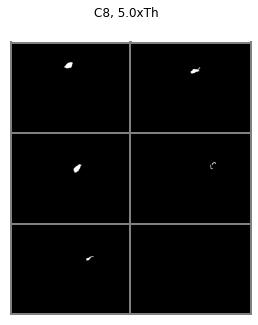

In [90]:
plot_double_singles("12-005", 89)

In [66]:
multi.iloc[20:30]

,subject,amp1,amp2,area,compactness,date,eccentricity,elec_delay,electrode1,electrode2,...,implant,num_regions,orientation,pdur,stim_class,trial,x_center,y_center,img_shape,has_single
70,12-005,5.0,5.0,809,0.668102,20091028,0.910101,0.0,A10,C10,...,ArgusII,2,1.474412,0.45,MultiElectrode,3,256.0,192.0,"(384, 512)",True
71,12-005,5.0,5.0,1219,0.870311,20091028,0.550560,0.0,A10,C10,...,ArgusII,1,-0.369993,0.45,MultiElectrode,23,256.0,192.0,"(384, 512)",True
72,12-005,5.0,5.0,574,0.844364,20091028,0.508225,0.0,A10,C10,...,ArgusII,2,-0.217523,0.45,MultiElectrode,27,256.0,192.0,"(384, 512)",True
73,12-005,5.0,5.0,1516,0.863089,20091028,0.687110,0.0,A10,C10,...,ArgusII,1,-0.837704,0.45,MultiElectrode,46,256.0,192.0,"(384, 512)",True
74,12-005,5.0,5.0,1196,0.621243,20091028,0.841022,0.0,A10,C10,...,ArgusII,1,-0.849276,0.45,MultiElectrode,51,256.0,192.0,"(384, 512)",True
85,12-005,5.0,5.0,835,0.678849,20091028,0.503957,0.0,C8,C10,...,ArgusII,1,-0.951489,0.45,MultiElectrode,6,256.0,192.0,"(384, 512)",True
86,12-005,5.0,5.0,639,0.549901,20091028,0.869100,0.0,C8,C10,...,ArgusII,1,-1.267117,0.45,MultiElectrode,16,256.0,192.0,"(384, 512)",True
87,12-005,5.0,5.0,445,0.623956,20091028,0.919125,0.0,C8,C10,...,ArgusII,1,-0.714702,0.45,MultiElectrode,26,256.0,192.0,"(384, 512)",True
88,12-005,5.0,5.0,785,0.697639,20091028,0.875607,0.0,C8,C10,...,ArgusII,1,-1.029558,0.45,MultiElectrode,44,256.0,192.0,"(384, 512)",True
89,12-005,5.0,5.0,409,0.302108,20091028,0.951974,0.0,C8,C10,...,ArgusII,1,-1.147117,0.45,MultiElectrode,59,256.0,192.0,"(384, 512)",True
